In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch

import sys
import os
import json

from ExptTrace import ExptTrace
from FileManager import FileManager
from misc import rcsetup

rcsetup()

sys.path.append("../")
from utils import ensure_torch, ensure_numpy
from kernels import GaussianKernel, LaplaceKernel, ReluNTK
from eigenlearning import compute_learnabilities, learning_curve
from feature_decomp import Monomial

In [2]:
import importlib
import feature_decomp
importlib.reload(feature_decomp)
from feature_decomp import Monomial



In [3]:
import matplotlib.colors as mcolors

def lighten(color, amount=0.5):
    rgb = mcolors.to_rgb(mcolors.XKCD_COLORS.get(color, color))
    if amount >= 0:
        new_rgb = tuple(c + (1 - c) * amount for c in rgb)
    else:
        new_rgb = tuple(c * (1 + amount) for c in rgb)
    # Clip values to [0, 1]
    new_rgb = tuple(min(max(x, 0), 1) for x in new_rgb)
    return new_rgb

In [4]:
import importlib
import expts.expt_demux
importlib.reload(expts.expt_demux)
from expts.expt_demux import expt_demux

def load_results(expt_id):
    EXPT_NAME = "learning-curves"

    hypers = expt_demux(expt_id)

    N_SAMPLES = hypers['n_samples']
    N_KERNEL = hypers['n_kernel']
    N_TRAIN_MAX = hypers['n_train_max']
    N_TEST = hypers['n_test']
    P_MODES = hypers['p_modes']
    DATASET = hypers['dataset']
    DATA_DIM = hypers['data_dim']
    DATA_EIGVAL_EXP = hypers['data_eigval_exp']
    ZCA_STRENGTH = hypers['zca_strength']
    NORMALIZE = hypers['normalize']
    TARGET = hypers['target']
    NUM_MARKERS = hypers['num_markers']
    KERNEL_NAME = hypers['kernel_name']
    KERNEL_WIDTH = hypers['kernel_width']
    RIDGE = hypers['ridge']
    FEWER_TRIALS = hypers['fewer_trials']

    datapath = os.getenv("DATASETPATH")
    exptpath = os.getenv("EXPTPATH")
    if datapath is None:
        raise ValueError("must set $DATASETPATH environment variable")
    if exptpath is None:
        raise ValueError("must set $EXPTPATH environment variable")
    fp = f"{KERNEL_NAME}-kw:{KERNEL_WIDTH}-target:{TARGET}"
    if DATASET == "gaussian":
        fp += f"-data:{DATA_DIM}:{DATA_EIGVAL_EXP}"
    else:
        fp += f"-zca:{ZCA_STRENGTH}"
    expt_dir = os.path.join(exptpath, "phlab", EXPT_NAME, DATASET, fp)

    if not os.path.exists(expt_dir):
        assert False, f"Experiment directory {expt_dir} does not exist"
    expt_fm = FileManager(expt_dir)
    
    with open(expt_fm.get_filename("hypers.json"), 'r') as f:
        hypers = json.load(f)
    result = expt_fm.load("result.pickle")
    targets = expt_fm.load("targets.pickle")
    coeffs = expt_fm.load("coeffs.pickle")
    return hypers, result, targets, coeffs


In [5]:
def add_lrn_curves(ax, expt_id, **kwargs):
    colors = ['xkcd:black', 'xkcd:raspberry', 'xkcd:cerulean', 'xkcd:grass', 'xkcd:tangerine']
    hypers, result, targets, coeffs = load_results(expt_id)
    RIDGE = hypers.get("ridge", 1e-3)
    TARGET = hypers.get("target", "powerlaws")
    label = kwargs.get("label", TARGET)
    color_idx = kwargs.get("color", 0)
    color = colors[color_idx % len(colors)]

    d_eff = result["d_eff"]
    et_mse = ExptTrace.deserialize(result["mse"])
    ntrains = et_mse.get_axis("ntrain")
    emp_eigvals = result["emp_eigvals"]
    emp_eigvals = np.maximum(emp_eigvals, 0)
    hehe_eigvals = result["th_eigvals"]

    target = list(targets.keys())[0]

    v_hat, v_emp = coeffs[target]
    
    xmin = kwargs.get("xmin", 8)
    xmax = kwargs.get("xmax", 2e4)

    mse = et_mse[:, :, target].squeeze()
    lrn_curve_emp, lrn_curve_emp_std = mse.mean(axis=0), mse.std(axis=0)
    ax.errorbar(ntrains, lrn_curve_emp, yerr=lrn_curve_emp_std, color=lighten(color, 0.5),
                ls='none', marker='o', zorder=-4)

    # emp_learnabilities, _ = compute_learnabilities(ntrains_dense, emp_eigvals, RIDGE)
    # lrn_curve_emp = learning_curve(ntrains_dense, emp_learnabilities, v_emp)
    # ax.plot(ntrains_dense, lrn_curve_emp, color=color, lw=2, ls=":")
    
    TrK = 1.0
    ntrains_dense = np.logspace(np.log10(xmin), np.log10(xmax), 200)
    hehe_ridge = RIDGE + max(0, TrK - hehe_eigvals.sum())
    learnabilities, _ = compute_learnabilities(ntrains_dense, hehe_eigvals, hehe_ridge)
    th_noise_var = 1 - np.linalg.norm(v_hat)**2
    lrn_curve_th = learning_curve(ntrains_dense, learnabilities, v_hat, noise_var=th_noise_var)
    ax.plot(ntrains_dense, lrn_curve_th, color=color, lw=2, ls="-", label=label)

In [6]:
from tqdm import tqdm

def get_sample_complexities(expt_id, **kwargs):
    hypers, result, targets, coeffs = load_results(expt_id)
    RIDGE = hypers.get("ridge")

    d_eff = result["d_eff"]
    et_mse = ExptTrace.deserialize(result["mse"])
    ntrains = et_mse.get_axis("ntrain")
    hehe_eigvals = result["th_eigvals"]
    monomials = result["monomials"]

    threshold = kwargs.get("threshold", 0.5)
    sample_complexities = {}
    ntrains_dense = np.logspace(np.log10(1), np.log10(20_000), 200)
    for idx, _ in tqdm(targets.items()):
        ntrains = et_mse.get_axis("ntrain")
        mse = et_mse[:, :, idx].squeeze()
        # mse = mse * 5/8
        lrn_curve_emp = mse.mean(axis=0)
        
        n_cross = 10**np.interp(threshold, lrn_curve_emp[::-1], np.log10(ntrains)[::-1])
        if n_cross > 0.99 * ntrains[-1]:
            continue

        v_hat, _ = coeffs[idx]
        TrK = 1.0
        hehe_ridge = RIDGE + max(0, TrK - hehe_eigvals.sum())
        learnabilities, _ = compute_learnabilities(ntrains_dense, hehe_eigvals, hehe_ridge)
        th_noise_var = 1 - np.linalg.norm(v_hat)**2
        lrn_curve_th = learning_curve(ntrains_dense, learnabilities, v_hat, noise_var=th_noise_var)
        n_cross_th = 10**np.interp(threshold, lrn_curve_th[::-1], np.log10(ntrains_dense)[::-1])

        sample_complexities[idx] = (n_cross, n_cross_th)
    return monomials, sample_complexities

# Fig 3

In [7]:
hypers, result, gkcfm_targets, coeffs = load_results(9)
RIDGE = hypers["ridge"]
TARGET = hypers["target"]

d_eff = result["d_eff"]
print(f"d_eff = {d_eff:.2f}")
et_mse = ExptTrace.deserialize(result["mse"])
ntrains = et_mse.get_axis("ntrain")
emp_eigvals = result["emp_eigvals"]
emp_eigvals = np.maximum(emp_eigvals, 0)
hehe_eigvals = result["th_eigvals"]
monomials = result["monomials"]

tags = [{10:1}, {190:1},
        {0:2}, {1:1, 3:1}, {16:1,20:1},
        {0:3}, {0:1, 1:1, 2:1},]

gkcfm_lrn_curves_emp = {}
gkcfm_lrn_curves_th = {}
for i, (idx, ystar) in enumerate(gkcfm_targets.items()):
    m = Monomial(monomials[idx])
    if m not in tags:
        print(str(m))
        continue
    v_hat, v_emp = coeffs[idx]

    mse = et_mse[:, :, idx].squeeze()
    lrn_curve_emp, lrn_curve_emp_std = mse.mean(axis=0), mse.std(axis=0)
    gkcfm_lrn_curves_emp[idx] = (ntrains, lrn_curve_emp, lrn_curve_emp_std)

    # emp_learnabilities, _ = compute_learnabilities(ntrains_dense, emp_eigvals, RIDGE)
    # lrn_curve_emp = learning_curve(ntrains_dense, emp_learnabilities, v_emp)
    # ax.plot(ntrains_dense, lrn_curve_emp, color=color, lw=2, ls=":")

    TrK = 1.0
    ntrains_dense = np.logspace(np.log10(10), np.log10(2e4), 200)
    hehe_ridge = RIDGE + max(0, TrK - hehe_eigvals.sum())
    learnabilities, _ = compute_learnabilities(ntrains_dense, hehe_eigvals, hehe_ridge)
    th_noise_var = 1 - np.linalg.norm(v_hat)**2
    lrn_curve_th = learning_curve(ntrains_dense, learnabilities, v_hat, noise_var=th_noise_var)
    gkcfm_lrn_curves_th[idx] = (ntrains_dense, lrn_curve_th)

d_eff = 9.18
$z_{0}$
$z_{100}$
$z_{0}z_{1}$
$z_{20}z_{30}$
$z_{1}z_{3}z_{4}$
$z_{0}^4$
$z_{3}^2z_{5}$


In [17]:
hypers, result, ntk_targets, coeffs = load_results(21)
RIDGE = hypers.get("ridge", 1e-3)

d_eff = result["d_eff"]
print(f"d_eff = {d_eff:.2f}")
et_mse = ExptTrace.deserialize(result["mse"])
ntrains = et_mse.get_axis("ntrain")
emp_eigvals = result["emp_eigvals"]
emp_eigvals = np.maximum(emp_eigvals, 0)
hehe_eigvals = result["th_eigvals"]

ntk_lrn_curves_emp = {}
ntk_lrn_curves_th = {}
for i, (target, ystar) in enumerate(ntk_targets.items()):
    
    v_hat, v_emp = coeffs[target]

    mse = et_mse[:, :, target].squeeze()
    lrn_curve_emp, lrn_curve_emp_std = mse.mean(axis=0), mse.std(axis=0)
    ntk_lrn_curves_emp[target] = (ntrains, lrn_curve_emp, lrn_curve_emp_std)

    # emp_learnabilities, _ = compute_learnabilities(ntrains_dense, emp_eigvals, RIDGE)
    # lrn_curve_emp = learning_curve(ntrains_dense, emp_learnabilities, v_emp)
    # ax.plot(ntrains_dense, lrn_curve_emp, color=color, lw=2, ls=":")

    TrK = 1.0
    ntrains_dense = np.logspace(np.log10(10), np.log10(1e4), 200)
    hehe_ridge = RIDGE + max(0, TrK - hehe_eigvals.sum())
    learnabilities, _ = compute_learnabilities(ntrains_dense, hehe_eigvals, hehe_ridge)
    th_noise_var = 1 - np.linalg.norm(v_hat)**2
    lrn_curve_th = learning_curve(ntrains_dense, learnabilities, v_hat, noise_var=th_noise_var)
    ntk_lrn_curves_th[target] = (ntrains_dense, lrn_curve_th)


d_eff = 69.76


In [18]:
hypers, result, targets, coeffs = load_results(8)
RIDGE = hypers.get("ridge")

d_eff = result["d_eff"]
et_mse = ExptTrace.deserialize(result["mse"])
ntrains = et_mse.get_axis("ntrain")
hehe_eigvals = result["th_eigvals"]
monomials_sc = result["monomials"]

threshold = 0.5
sample_complexities = {}
ntrains_dense = np.logspace(np.log10(1), np.log10(20_000), 200)
for idx, _ in tqdm(targets.items()):
    ntrains = et_mse.get_axis("ntrain")
    mse = et_mse[:, :, idx].squeeze()
    lrn_curve_emp = mse.mean(axis=0)
    
    n_cross = 10**np.interp(threshold, lrn_curve_emp[::-1], np.log10(ntrains)[::-1])
    if n_cross > 0.99 * ntrains[-1]:
        continue

    v_hat, _ = coeffs[idx]
    TrK = 1.0
    hehe_ridge = RIDGE + max(0, TrK - hehe_eigvals.sum())
    learnabilities, _ = compute_learnabilities(ntrains_dense, hehe_eigvals, hehe_ridge)
    th_noise_var = 1 - np.linalg.norm(v_hat)**2
    lrn_curve_th = learning_curve(ntrains_dense, learnabilities, v_hat, noise_var=th_noise_var)
    n_cross_th = 10**np.interp(threshold, lrn_curve_th[::-1], np.log10(ntrains_dense)[::-1])

    sample_complexities[idx] = (n_cross, n_cross_th)

  0%|          | 0/118 [00:00<?, ?it/s]

100%|██████████| 118/118 [00:51<00:00,  2.29it/s]


.....
....


'created' timestamp seems very low; regarding as unix timestamp
'modified' timestamp seems very low; regarding as unix timestamp
'created' timestamp seems very low; regarding as unix timestamp
'modified' timestamp seems very low; regarding as unix timestamp
'created' timestamp seems very low; regarding as unix timestamp
'modified' timestamp seems very low; regarding as unix timestamp


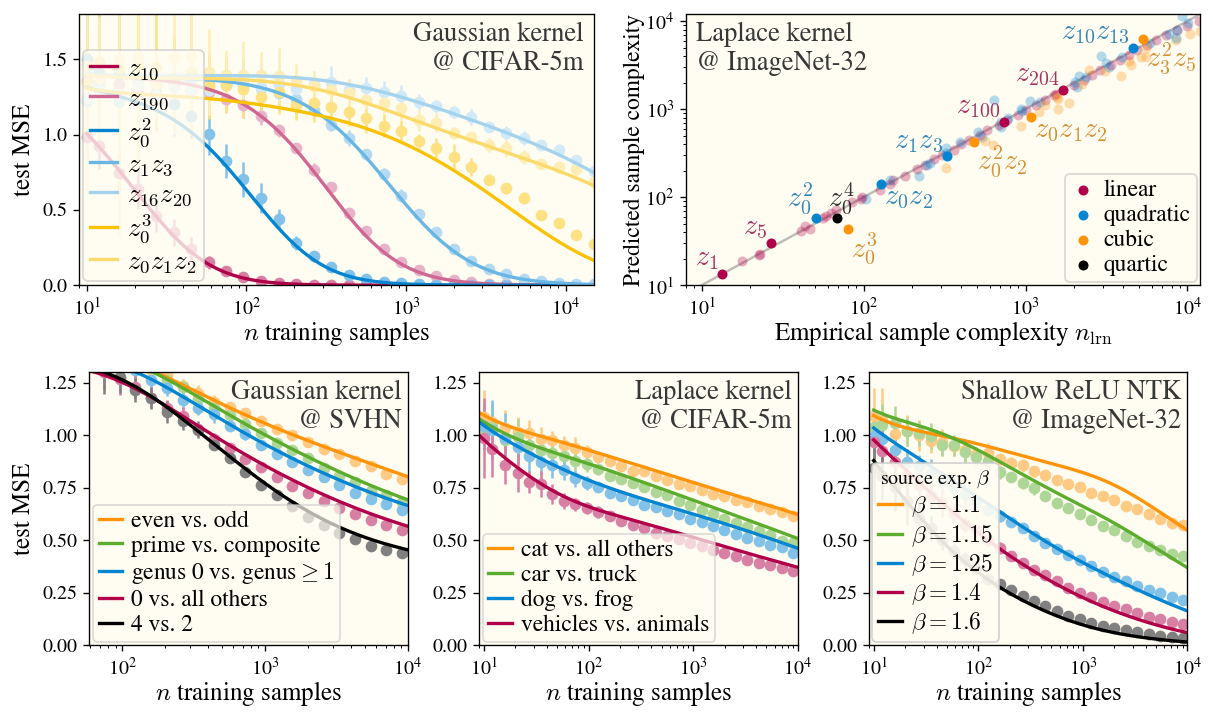

In [ ]:
import matplotlib.pyplot as plt

fig = plt.figure(constrained_layout=True, figsize=(10, 6))
fig.set_constrained_layout_pads(h_pad=0.1)
gs = fig.add_gridspec(2, 1)

# top row: 2 equal axes
gs_top = gs[0].subgridspec(1, 2, wspace=0.05)
ax1 = fig.add_subplot(gs_top[0, 0])
ax2 = fig.add_subplot(gs_top[0, 1])

# bottom row: 3 equal axes
gs_bottom = gs[1].subgridspec(1, 3)
ax3 = fig.add_subplot(gs_bottom[0, 0])
ax4 = fig.add_subplot(gs_bottom[0, 1])
ax5 = fig.add_subplot(gs_bottom[0, 2])


# TOP LEFT
##############

ax = ax1
xmin, xmax = 9, 1.5e4
# colors = [None, 'xkcd:brown', 'xkcd:bright blue', 'xkcd:green']
colors = [None, 'xkcd:raspberry', 'xkcd:cerulean', 'xkcd:goldenrod']

cinds = [0, 1,
         0, 1, 2,
         0, 1]
for i, m in enumerate(tags):
    idx = monomials.index(m)
    m = Monomial(monomials[idx])
    label = str(m)
    color = colors[m.degree()]
    for _ in range(cinds[i]):
        color = lighten(color, 0.4)
    ntrains, lrn_curve_emp, lrn_curve_emp_std = gkcfm_lrn_curves_emp[idx]
    ax.errorbar(ntrains, lrn_curve_emp, yerr=lrn_curve_emp_std, color=lighten(color, 0.5),
                ls='none', marker='o', zorder=-4)

    ntrains_dense, lrn_curve_th = gkcfm_lrn_curves_th[idx]
    ax.plot(ntrains_dense, lrn_curve_th, color=color, lw=2, ls="-", label=label)

ax.set_xlabel(f"$n$ training samples", fontsize=15, labelpad=0)
ax.set_ylabel("test MSE", fontsize=15)
ax.text(0.98, 0.97, f"Gaussian kernel\n@ CIFAR-5m", ha="right", va="top",
        transform=ax.transAxes, fontsize=16, color="xkcd:dark gray")

ax.set_xscale("log")
ax.set_xlim(xmin, xmax)
ax.set_ylim(0, 1.8)
ax.legend(fontsize=16, framealpha=0.8,
          handlelength=1, labelspacing=0.15,
          borderpad=0.25, bbox_to_anchor=(0, 0),
          loc='lower left',
          handletextpad=0.4,
          borderaxespad=0.15,
          )

# TOP RIGHT
##############

ax = ax2
xmin, xmax = 9, 1e4
tags_sc = [{1:1}, {5:1}, {100:1}, {204:1},
        {0:2}, {0:1,2:1}, {1:1, 3:1}, {10:1,13:1}, {20:1,30:1},
        {0:3}, {0:2, 2:1}, {0:1, 1:1, 2:1}, {3:2, 5:1},
        {0:4}]
locs = [3, 3, 3, 3,
        3, 0, 3, 3, 0,
        0, 0, 0, 0,
        1]

# colors = ['xkcd:red', 'xkcd:orange', 'xkcd:gold', 'xkcd:green', 'xkcd:blue']
colors = ['xkcd:red', 'xkcd:raspberry', 'xkcd:cerulean', 'xkcd:tangerine', 'xkcd:black']
labeldone = [False] * len(colors)
labels = ["constant", "linear", "quadratic", "cubic", "quartic"]
for idx, (n_emp, n_th) in sample_complexities.items():
    m = Monomial(monomials_sc[idx])
    color = colors[m.degree() % len(colors)]
    alpha = 0.3
    zorder = -3
    label = None
    # if n_th > 2*n_emp:
    #     continue
    if m in tags_sc:
        i = tags_sc.index(monomials_sc[idx])
        kwargs = {"ha": "left" if locs[i] < 2 else "right",
                  "va": "bottom" if locs[i] % 2 == 1 else "top"}
        z = 0.05
        off = (
            z if locs[i] < 2 else -z,
            z if locs[i] % 2 == 1 else -z
        )
        if m == {0:4}:
            kwargs["ha"] = "center"
        ax.annotate(str(m), (n_emp*(1+off[0]), n_th*(1+off[1])), fontsize=17,
                    color=lighten(color, -0.2), alpha=0.8, **kwargs)
        alpha = 1.0
        zorder = 1
        label = None if labeldone[m.degree()] else labels[m.degree()]
        labeldone[m.degree()] = True
    ax.scatter(n_emp, n_th, color=color, alpha=alpha, lw=0, zorder=zorder, label=label)

ax.text(0.02, 0.97, f"Laplace kernel\n@ ImageNet-32", ha="left", va="top",
        transform=ax.transAxes, fontsize=16, color="xkcd:dark gray")
ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xlim(8, 1.2e4)
ax.set_ylim(10, 1.2e4)
ax.plot([1, 2e4], [1, 2e4], color="gray", alpha=0.5, zorder=-4)
ax.legend(fontsize=14, framealpha=0.8,
          handlelength=1, labelspacing=0.15,
          borderpad=0.25,
          loc='lower right',
          handletextpad=0.4,
          borderaxespad=0.15,
          )
ax.set_xlabel(f"Empirical sample complexity $n_\\mathrm{{lrn}}$",
              fontsize=15, labelpad=0)
ax.set_ylabel(f"Predicted sample complexity", fontsize=14, labelpad=0)

# BOTTOM LEFT
##############

ax = ax3
xmin, xmax = 59, 1e4

for i, expt_id in enumerate([11, 13, 12, 16, 14]):
    print(".", end="", flush=True)
    hypers, result, targets, coeffs = load_results(expt_id)
    if expt_id == 11:
        label = "even vs. odd"
    if expt_id == 12:
        label = f"genus 0 vs. genus$\\geq 1$"
    if expt_id == 13:
        label = "prime vs. composite"
    if expt_id == 14:
        label = "4 vs. 2"
    if expt_id == 16:
        label = "0 vs. all others"
    add_lrn_curves(ax, expt_id, xmin=xmin, xmax=xmax,
                   color=-(i+1), label=label)
print()

ax.set_xlabel(f"$n$ training samples", fontsize=15, labelpad=0)
ax.set_ylabel("test MSE", fontsize=15)
ax.text(0.98, 0.97, f"Gaussian kernel\n@ SVHN", ha="right", va="top",
        transform=ax.transAxes, fontsize=16, color="xkcd:dark gray")

ax.set_xscale("log")
ax.set_xlim(xmin, xmax)
ax.set_ylim(0, 1.3)
ax.legend(fontsize=14,
          framealpha=0.7,
          handlelength=1, labelspacing=0.15,
          borderpad=0.25, bbox_to_anchor=(0, 0),
          loc='lower left',
          handletextpad=0.4,
          borderaxespad=0.15,
          )

# BOTTOM CENTER
##############

ax = ax4
xmin, xmax = 9, 1e4

for i, expt_id in enumerate([18, 20, 19, 17]):
    print(".", end="", flush=True)
    if expt_id == 17:
        label = "vehicles vs. animals"
    if expt_id == 18:
        label = "cat vs. all others"
    if expt_id == 19:
        label = "dog vs. frog"
    if expt_id == 20:
        label = "car vs. truck"
    add_lrn_curves(ax, expt_id, xmin=xmin, xmax=xmax,
               color=-(i+1), label=label)
print()

ax.set_xlabel(f"$n$ training samples", fontsize=15, labelpad=0)
# ax.set_ylabel("test MSE", fontsize=15)
ax.text(0.98, 0.97, f"Laplace kernel\n@ CIFAR-5m", ha="right", va="top",
        transform=ax.transAxes, fontsize=16, color="xkcd:dark gray")

ax.set_xscale("log")
ax.set_xlim(xmin, xmax)
ax.set_ylim(0, 1.3)
ax.legend(fontsize=14,
          framealpha=0.7,
          handlelength=1, labelspacing=0.15,
          borderpad=0.25, bbox_to_anchor=(0, 0),
          loc='lower left',
          handletextpad=0.4,
          borderaxespad=0.15,
          )


# BOTTOM RIGHT
##############

ax = ax5
colors = [None, 'xkcd:black', 'xkcd:raspberry', 'xkcd:cerulean', 'xkcd:grass', 'xkcd:tangerine']

for i, (target, ystar) in enumerate(ntk_targets.items()):
    if target == 1.05:
        continue
    label = f"$\\beta={target}$"
    
    color = colors[-(i % len(colors))]
    
    n_trains, lrn_curve_emp , lrn_curve_emp_std = ntk_lrn_curves_emp[target]
    ax.errorbar(ntrains, lrn_curve_emp, yerr=lrn_curve_emp_std, color=lighten(color, 0.5),
                ls='none', marker='o', zorder=-4)

    ntrains_dense, lrn_curve_th = ntk_lrn_curves_th[target]
    ax.plot(ntrains_dense, lrn_curve_th, color=color, lw=2, ls="-", label=label)

ax.set_xlabel(f"$n$ training samples", fontsize=15, labelpad=0)
# ax.set_ylabel("test MSE", fontsize=15)
ax.text(0.98, 0.97, f"Shallow ReLU NTK\n@ ImageNet-32", ha="right", va="top",
        transform=ax.transAxes, fontsize=16, color="xkcd:dark gray")

ax.set_xscale("log")
ax.set_xlim(xmin, xmax)
ax.set_ylim(0, 1.3)
ax.legend(fontsize=14, title="source exp. $\\beta$",
          framealpha=0.9,
          handlelength=1, labelspacing=0.15,
          borderpad=0.25, bbox_to_anchor=(0, 0),
          loc='lower left',
          handletextpad=0.4,
          borderaxespad=0.15,
          )

# plt.show()
plt.savefig("fig3.pdf", bbox_inches='tight')

# Panel 0

In [122]:
xmin, xmax = 9, 1e4

hypers, result, targets, coeffs = load_results(25)
RIDGE = hypers["ridge"]
TARGET = hypers["target"]

d_eff = result["d_eff"]
print(f"d_eff = {d_eff:.2f}")
et_mse = ExptTrace.deserialize(result["mse"])
ntrains = et_mse.get_axis("ntrain")
emp_eigvals = result["emp_eigvals"]
emp_eigvals = np.maximum(emp_eigvals, 0)
hehe_eigvals = result["th_eigvals"]
monomials = result["monomials"]

tags = [{10:1}, {190:1},
        {0:2}, {1:1, 3:1}, {16:1,20:1},
        {0:3}, {0:1, 1:1, 2:1},]

lrn_curves_emp = {}
lrn_curves_th = {}
for i, (idx, ystar) in enumerate(targets.items()):
    m = Monomial(monomials[idx])
    if m not in tags:
        print(str(m))
        continue
    v_hat, v_emp = coeffs[idx]

    mse = et_mse[:, :, idx].squeeze()
    lrn_curve_emp, lrn_curve_emp_std = mse.mean(axis=0), mse.std(axis=0)
    lrn_curves_emp[idx] = (lrn_curve_emp, lrn_curve_emp_std)

    # emp_learnabilities, _ = compute_learnabilities(ntrains_dense, emp_eigvals, RIDGE)
    # lrn_curve_emp = learning_curve(ntrains_dense, emp_learnabilities, v_emp)
    # ax.plot(ntrains_dense, lrn_curve_emp, color=color, lw=2, ls=":")

    TrK = 1.0
    ntrains_dense = np.logspace(np.log10(xmin), np.log10(xmax), 200)
    hehe_ridge = RIDGE + max(0, TrK - hehe_eigvals.sum())
    learnabilities, _ = compute_learnabilities(ntrains_dense, hehe_eigvals, hehe_ridge)
    th_noise_var = 1 - np.linalg.norm(v_hat)**2
    lrn_curve_th = learning_curve(ntrains_dense, learnabilities, v_hat, noise_var=th_noise_var)
    lrn_curves_th[idx] = lrn_curve_th

d_eff = 9.18
$x_{0}$
$x_{100}$
$x_{0}x_{1}$
$x_{20}x_{30}$
$x_{1}x_{3}x_{4}$
$x_{0}^4$
$x_{3}^2x_{5}$


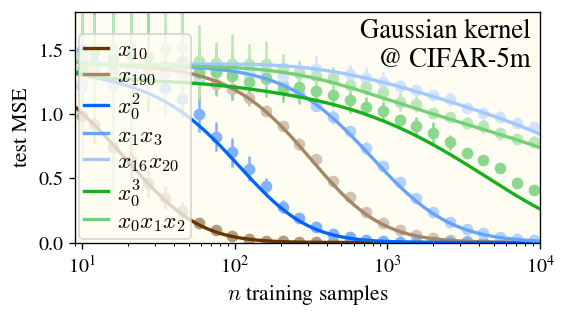

In [ ]:
fig, ax = plt.subplots(figsize=(5, 2.5))

colors = ['xkcd:deep purple', 'xkcd:magenta',
          'xkcd:bright blue', 'xkcd:dark sky blue', 'xkcd:sky',
          'xkcd:tangerine', 'xkcd:sunflower',]
colors = [None, 'xkcd:brown', 'xkcd:bright blue', 'xkcd:green']

cinds = [0, 1,
         0, 1, 2,
         0, 1]
for i, m in enumerate(tags):
    idx = monomials.index(m)
    m = Monomial(monomials[idx])
    label = str(m)
    color = colors[m.degree()]
    for _ in range(cinds[i]):
        color = lighten(color, 0.4)
    lrn_curve_emp, lrn_curve_emp_std = lrn_curves_emp[idx]
    ax.errorbar(ntrains, lrn_curve_emp, yerr=lrn_curve_emp_std, color=lighten(color, 0.5),
                ls='none', marker='o', zorder=-4)
    
    lrn_curve_th = lrn_curves_th[idx]
    ax.plot(ntrains_dense, lrn_curve_th, color=color, lw=2, ls="-", label=label)

ax.set_xlabel(f"$n$ training samples", fontsize=13)
ax.set_ylabel("test MSE", fontsize=13)
ax.text(0.98, 0.97, f"Gaussian kernel\n@ CIFAR-5m", ha="right", va="top",
        transform=ax.transAxes, fontsize=16, color="xkcd:dark gray")

ax.set_xscale("log")
ax.set_xlim(xmin, xmax)
ax.set_ylim(0, 1.8)
ax.legend(fontsize=14, framealpha=0.8,
          handlelength=1, labelspacing=0.15,
          borderpad=0.25, bbox_to_anchor=(0, 0),
          loc='lower left',
          handletextpad=0.4,
          borderaxespad=0.15,
          )
plt.show()

# Panel 1

In [118]:
xmin, xmax = 9, 1e4

hypers, result, targets, coeffs = load_results(15)
RIDGE = hypers.get("ridge", 1e-3)

d_eff = result["d_eff"]
print(f"d_eff = {d_eff:.2f}")
et_mse = ExptTrace.deserialize(result["mse"])
ntrains = et_mse.get_axis("ntrain")
emp_eigvals = result["emp_eigvals"]
emp_eigvals = np.maximum(emp_eigvals, 0)
hehe_eigvals = result["th_eigvals"]

lrn_curves_emp = {}
lrn_curves_th = {}
for i, (target, ystar) in enumerate(targets.items()):
    
    v_hat, v_emp = coeffs[target]

    mse = et_mse[:, :, target].squeeze()
    lrn_curve_emp, lrn_curve_emp_std = mse.mean(axis=0), mse.std(axis=0)
    lrn_curves_emp[target] = (lrn_curve_emp, lrn_curve_emp_std)

    # emp_learnabilities, _ = compute_learnabilities(ntrains_dense, emp_eigvals, RIDGE)
    # lrn_curve_emp = learning_curve(ntrains_dense, emp_learnabilities, v_emp)
    # ax.plot(ntrains_dense, lrn_curve_emp, color=color, lw=2, ls=":")

    TrK = 1.0
    ntrains_dense = np.logspace(np.log10(xmin), np.log10(xmax), 200)
    hehe_ridge = RIDGE + max(0, TrK - hehe_eigvals.sum())
    learnabilities, _ = compute_learnabilities(ntrains_dense, hehe_eigvals, hehe_ridge)
    th_noise_var = 1 - np.linalg.norm(v_hat)**2
    lrn_curve_th = learning_curve(ntrains_dense, learnabilities, v_hat, noise_var=th_noise_var)
    lrn_curves_th[target] = lrn_curve_th


d_eff = 69.76


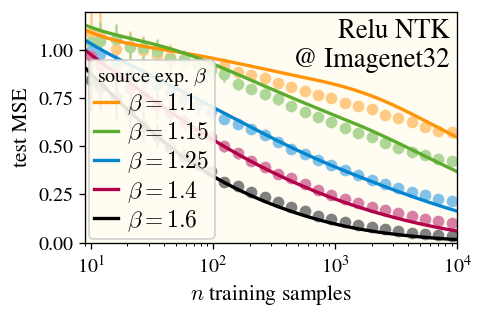

In [ ]:
fig, ax = plt.subplots(figsize=(4, 2.5))

colors = [None, 'xkcd:black', 'xkcd:raspberry', 'xkcd:cerulean', 'xkcd:grass', 'xkcd:tangerine']

for i, (target, ystar) in enumerate(targets.items()):
    if target == 1.05:
        continue
    label = f"$\\beta={target}$"
    
    color = colors[-(i % len(colors))]
    
    lrn_curve_emp , lrn_curve_emp_std = lrn_curves_emp[target]
    ax.errorbar(ntrains, lrn_curve_emp, yerr=lrn_curve_emp_std, color=lighten(color, 0.5),
                ls='none', marker='o', zorder=-4)

    lrn_curve_th = lrn_curves_th[target]
    ax.plot(ntrains_dense, lrn_curve_th, color=color, lw=2, ls="-", label=label)

ax.set_xlabel(f"$n$ training samples", fontsize=13)
ax.set_ylabel("test MSE", fontsize=13)
ax.text(0.98, 0.97, f"Relu NTK\n@ Imagenet32", ha="right", va="top",
        transform=ax.transAxes, fontsize=16, color="xkcd:dark gray")

ax.set_xscale("log")
ax.set_xlim(xmin, xmax)
ax.set_ylim(0, 1.2)
ax.legend(fontsize=14, title="source exp. $\\beta$",
          framealpha=0.9,
          handlelength=1, labelspacing=0.15,
          borderpad=0.25, bbox_to_anchor=(0, 0),
          loc='lower left',
          handletextpad=0.4,
          borderaxespad=0.15,
          )
plt.show()

# Panel 2

d_eff = 39.70
d_eff = 46.24
d_eff = 44.19
d_eff = 40.22


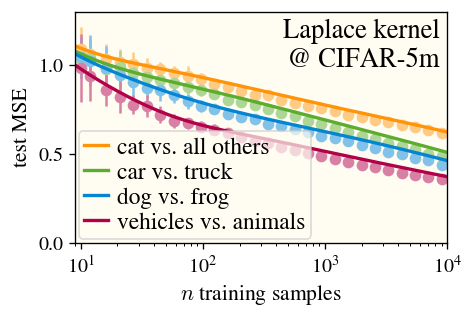

In [ ]:
fig, ax = plt.subplots(figsize=(4, 2.5))

xmin, xmax = 9, 1e4

for i, expt_id in enumerate([12, 14, 13, 11]):
    if expt_id == 11:
        label = "vehicles vs. animals"
    if expt_id == 12:
        label = "cat vs. all others"
    if expt_id == 13:
        label = "dog vs. frog"
    if expt_id == 14:
        label = "car vs. truck"
    add_lrn_curves(ax, expt_id, xmin=xmin, xmax=xmax,
               color=-(i+1), label=label)

ax.set_xlabel(f"$n$ training samples", fontsize=13)
ax.set_ylabel("test MSE", fontsize=13)
ax.text(0.98, 0.97, f"Laplace kernel\n@ CIFAR-5m", ha="right", va="top",
        transform=ax.transAxes, fontsize=16, color="xkcd:dark gray")

ax.set_xscale("log")
ax.set_xlim(xmin, xmax)
ax.set_ylim(0, 1.3)
ax.legend(fontsize=14,
          framealpha=0.7,
          handlelength=1, labelspacing=0.15,
          borderpad=0.25, bbox_to_anchor=(0, 0),
          loc='lower left',
          handletextpad=0.4,
          borderaxespad=0.15,
          )
plt.show()

# Panel 3

d_eff = 4.84
d_eff = 5.17
d_eff = 5.36
d_eff = 5.47


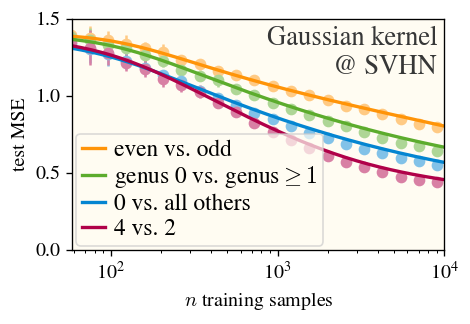

In [127]:
fig, ax = plt.subplots(figsize=(4, 2.5))

xmin, xmax = 59, 1e4

for i, expt_id in enumerate([20, 21, 24, 22]):
    hypers, result, targets, coeffs = load_results(expt_id)
    if expt_id == 20:
        label = "even vs. odd"
    if expt_id == 21:
        label = f"genus 0 vs. genus$\\geq 1$"
    if expt_id == 22:
        label = "4 vs. 2"
    if expt_id == 23:
        label = "4 vs. 9"
        continue
    if expt_id == 24:
        label = "0 vs. all others"
    add_lrn_curves(ax, expt_id, xmin=xmin, xmax=xmax,
               color=-(i+1), label=label)

ax.set_xlabel(f"$n$ training samples")
ax.set_ylabel("test MSE")
ax.text(0.98, 0.97, f"Gaussian kernel\n@ SVHN", ha="right", va="top",
        transform=ax.transAxes, fontsize=16, color="xkcd:dark gray")

ax.set_xscale("log")
ax.set_xlim(xmin, xmax)
ax.set_ylim(0, 1.5)
ax.legend(fontsize=14,
          framealpha=0.7,
          handlelength=1, labelspacing=0.15,
          borderpad=0.25, bbox_to_anchor=(0, 0),
          loc='lower left',
          handletextpad=0.4,
          borderaxespad=0.15,
          )
plt.show()